# `numpy` Neural Networks: Multi-Layer Perceptron

This is the first in a series of notebooks I'm planning on making to illustrate deep learning concepts to myself using clear math and simple examples. None of the code here is meant to be very performant, there are optimized libraries for that. Rather, it's useful for me to organize my thoughts.

We consider the case of binary classification in 2D. So we have a 2D input, and a single number as an output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

Let's make a toy 2D dataset to play with. We won't bother with a test set for now.

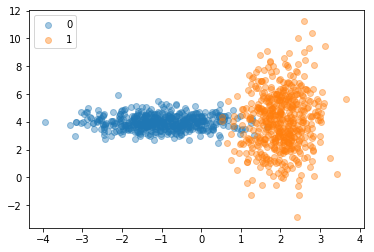

In [2]:
n_samples = 1000
X0 = np.random.normal(loc=[-1,4], scale=[1,0.5], size=(int(n_samples/2), 2))
X1 = np.random.normal(loc=[2,4], scale=[0.5,2], size=(int(n_samples/2), 2))
y0 = np.zeros(shape=(int(n_samples/2), ))
y1 = np.ones(shape=(int(n_samples/2), ))
X = np.vstack([X0, X1])
yhat = np.hstack([y0, y1])

plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

## Basic definitions

We will make use of the sigmoid the activation function:
$$ f(x) = \frac{1}{1+e^{-x}} $$

$$ \frac{\mathrm{d}f}{\mathrm{d}x} = f(x) \cdot (1-f(x)) $$

In [3]:
def f(x):
    return 1 / (1 + np.exp(-x))

def dfdx(x):
    return f(x) * (1 - f(x))

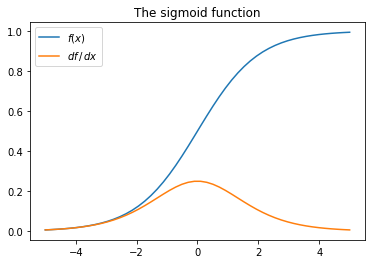

In [4]:
x = np.linspace(-5,5)
plt.plot(x, f(x), label='$f(x)$'); plt.plot(x, dfdx(x), label='$df\, /\,dx$'); plt.legend();
plt.title('The sigmoid function');

Each neuron (aka "unit") in the network accepts an array of inputs $x_i$ and has an associated weight vector $w_i$. The action of the unit is to take the inner product of $w$ and $x$ and pass this number through its activation function, $f$. So the output of a unit, $y$, is simply

$$ \mathrm{output} = f(w \cdot x) $$

If we have may layers, this output is then passed as input to the next layer of units. We will use the sigmoid function for all of our units. 


Our neural network will have one output unit, $y$. The output is between 0 and 1, since it is the result of a sigmoid function. We will refer to the true labels as $\hat y$ ("y hat").

Output: $y$, $0<y<1$

True label: $\hat y$ (1 or 0)


The cost function we will try to minimize during training is called the cross-entropy cost function and may be familiar from logistic regression:

$$ J(y, \hat y) = −(\hat y\log(y) + (1−\hat y)\log(1−y)) $$

$$ \frac{\partial J}{\partial y} = \frac{1-\hat y}{1-y} -\frac{\hat y}{y} $$

In [14]:
def J(y, yhat):
    return -(yhat * np.log(y) + (1-yhat) * np.log(1-y))

def dJdy(y, yhat):
    return (1-yhat)/(1-y) - yhat/y

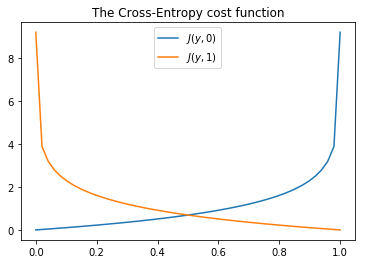

In [15]:
y = np.linspace(0.0001,0.9999)
plt.plot(y, J(y,0), label='$J(y,0)$'); plt.plot(y, J(y,1), label='$J(y,1)$'); plt.legend();
plt.title('The Cross-Entropy cost function');

## Case: No hidden layers

This is basically just logistic regression.

Input: $x_i$, $i=0,...,n$, where we fix $x_0 \equiv 1$ (the "bias term")

Weights: $w_{i}$, $i=0,...,n$

Output: 
$$y = f\left(\sum_i w_i x_i\right) = f(w \cdot x)$$

This is called the feedforward pass, where we make a prediction based on the input and current weights.

In [7]:
def forward(x, w):
    return f(np.dot(x, w))

To figure out what the weights should be, we want to update them by gradient descent along the cost function. We should move down the gradient, taking steps of size $\alpha$. Then our update rule is:

$$ w_i \rightarrow w_i - \alpha \frac{\partial J}{\partial w_i} \equiv w_i - \alpha \delta_i $$

Define $z \equiv w\cdot x$. Then:

\begin{align}
\frac{\partial J}{\partial w_i} &= \frac{\partial J(y, \hat y)}{\partial y} \frac{\partial y(z)}{\partial w_i}\\
 &= \frac{\partial J(y, \hat y)}{\partial y} \frac{\partial y(z)}{\partial z} \frac{ \partial z(w,x)}{\partial w_i} 
\end{align}


Since $z = x_i w_i$, we have $\partial z / \partial w_i = x_i$. Furthermore, $y(z) = f(z)$. We get:

\begin{align}
\delta_i = \frac{\partial J}{\partial w_i} &= \left[\frac{1-\hat y}{1-y(z)} - \frac{\hat y}{y(z)} \right]\left[ y(z)(1-y(z) \right]\left[ x_i \right]\\
&= \left(y(1-\hat y) - \hat y(1-y) \right)x_i
\end{align}

So our update rule is

$$ w_i \rightarrow w_i - \alpha \left(y(1-\hat y) - \hat y(1-y) \right)x_i $$



In [16]:
## Option one: use the given derivatives (clearer)
def backward1(x, w, y, yhat):
    z = np.dot(x,w)
    dzdw = x
    return dJdy(y, yhat) * dfdx(z) * dzdw

## Option two: use the explicit calculted form (faster)
def backward2(x, y, yhat):  # w not needed for this form
    return ( y*(1-yhat) - yhat*(1-y) ) * x

def update(w, alpha, delta):
    return w - alpha * delta

Now it's time to train! The training prodecure is as follows. For each sample:

1. Make our prediction $y$ based on the input sample $x$ (the forward pass)

2. Calculate the steps to take for updating the weights (the backward pass) and update them

We loop through the training set several times, making small updates at each step. Each single full cycle through the training set is called an "epoch".

In [17]:
def train(X, yhat, n_epoch, alpha):
    X_withbias = np.hstack([np.ones((X.shape[0],1)), X])  # fix x_0 = 1
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,))

    # random nonzero initialization
    w = np.random.normal(0.001, 0.001, size=(X.shape[1]+1,))  # +1 for the bias

    for epoch in range(n_epoch):
        for i, x in enumerate(X_withbias):
            y = forward(x, w)  # prediction for one sample
            delta = backward1(x,w, y, yhat[i])  # step to take, yhat[i] to just get this sample
            w = update(w, alpha, delta)  # update weights
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forward(X_withbias, w)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        
        # report progress
        if (epoch % 10 == 0) or (epoch == n_epoch - 1):
            accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
            print('Training accuracy after epoch {}: {:.4%}'.format(epoch, accuracy))
            
    return w, costs

In [18]:
n_epoch = 100
alpha = 0.001

w, costs = train(X, yhat, n_epoch, alpha)    

Training accuracy after epoch 0: 55.0000%
Training accuracy after epoch 10: 95.7000%
Training accuracy after epoch 20: 96.9000%
Training accuracy after epoch 30: 97.0000%
Training accuracy after epoch 40: 97.6000%
Training accuracy after epoch 50: 97.9000%
Training accuracy after epoch 60: 97.9000%
Training accuracy after epoch 70: 98.0000%
Training accuracy after epoch 80: 98.0000%
Training accuracy after epoch 90: 98.0000%
Training accuracy after epoch 99: 98.0000%


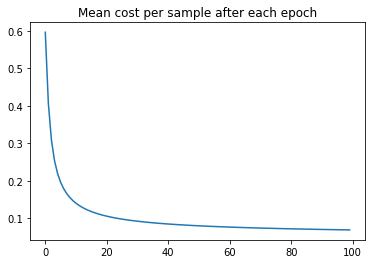

In [19]:
plt.plot(costs); plt.title('Mean cost per sample after each epoch');

Since we're working in 2D, we can visualize the function learned by our simple netowrk as a heatmap.

In [38]:
x1 = np.linspace(-5,5)
x2 = np.linspace(-4,13)
fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map[m,n] = forward([1,i,j], w)

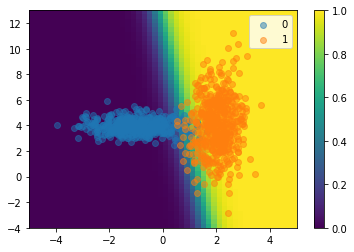

In [42]:
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X0.T, alpha=0.5, label='0'); plt.scatter(*X1.T, alpha=0.5, label=1)
plt.legend();

# Case: 1 Hidden Layer